In [1]:
import glob

import tensorflow as tf
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling

import os
import time
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

workerEnv = str(os.getenv("USER"))
workOnPrometheus = workerEnv.find("plg")>-1
inputDataPrefix = "/home/user1/scratch/akalinow/"
if workOnPrometheus:
    inputDataPrefix = "/net/people/plgakalinow/plggcmsml/"
dataDir = inputDataPrefix+"/ProgrammingProjects/MachineLearning/TauTauMass/data/29_06_2020/"   

massBins = np.concatenate(([0.0],np.arange(50.0, 300, 5), [300,9999.0]))

## Plotting functions

In [2]:
cumulativePosteriorCut = 0.50

def plotPosterior(massGen, labels, predictions):
    
    fig, axes = plt.subplots(1, 2, figsize = (10, 5))
    indices = np.logical_and(labels>massGen-2, labels<massGen+2)
    predictions = predictions[indices]
    predictions = np.mean(predictions, axis=0)
    maxPosterior = tf.math.reduce_max(predictions)
    scaleFactor = int(0.8/maxPosterior + 0.5)
    axes[0].plot(label2Mass(np.arange(predictions.shape[0])), scaleFactor*predictions, label="{}xposterior".format(scaleFactor))
    axes[0].plot(label2Mass(np.arange(predictions.shape[0])), np.cumsum(predictions), linestyle='-.',label="cumulative posterior")
    axes[1].plot(label2Mass(np.arange(predictions.shape[0])), scaleFactor*predictions, label="{}xposterior".format(scaleFactor))
    #axes[1].plot(label2Mass(np.arange(predictions.shape[0])), np.cumsum(predictions), label="cumulative posterior")
    
    predictions = np.cumsum(predictions, axis=0)>cumulativePosteriorCut
    predictions = np.argmax(predictions, axis=0)
    massRec = label2Mass(predictions)
    print("mass gen = @{}, mass rec @{} cumulative posterior: {}".format(massGen, cumulativePosteriorCut, massRec))
    axes[0].axvline(massGen, linestyle='-', color="olivedrab", label=r'$m^{GEN} \pm 4 [GeV/c]$')
    axes[0].axvline(massRec, linestyle='--', color="r", label=r'$m^{REC} @ cum~post.=$'+str(cumulativePosteriorCut))
    #axes[1].axvline(massGen, color="olivedrab", label=r'$p_{T}^{GEN} \pm 1 [GeV/c]$')
    #axes[1].axvline(massRec, color="r", label=r'$p_{T}^{REC} @ cum~post.=$'+str(cumulativePosteriorCut))
    
    axes[0].set_xlabel(r'$m [GeV/c^{2}]$')
    axes[0].set_ylabel('Value')
    axes[0].set_xlim([0, 2*massGen])
    axes[0].set_ylim([1E-3,1.05])
    
    axes[0].legend(bbox_to_anchor=(2.5,1), loc='upper left')
    axes[1].set_xlabel(r'$m [GeV/c^{2}]$')
    axes[1].set_ylabel('Value')
    axes[1].set_xlim([0,300])
    axes[1].set_ylim([1E-3,1.05])
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.3)
    plt.savefig("fig_png/Posterior_massGen_{}.png".format(massGen), ext='png', bbox_inches="tight")
    
    
def plotPull(labels, predictions, fastMTTPredictions):
    
    minX = -1
    maxX = 1
    nBins = 50
    error = (predictions - labels)/labels
    fastMTTError = (fastMTTPredictions - labels)/labels    
    fig, axes = plt.subplots(1, 2, figsize = (12, 5))  
    axes[0].hist(error, range=(minX, maxX), bins = nBins, color="deepskyblue", label = "NN")
    axes[0].hist(fastMTTError, range=(minX, maxX), bins = nBins, color="tomato", label="fastMTT")
    axes[0].set_xlabel("(Model - True)/True")
    axes[0].legend(loc='upper right')
    axes[0].set_xlim([minX, maxX])
    #axes[0].set_ylim([-2,2])
    
    axes[1].hist(fastMTTError, range=(minX, maxX), bins = nBins, color="tomato", label="fastMTT")
    axes[1].hist(error, range=(minX, maxX), bins = nBins, color="deepskyblue", label = "NN")
    axes[1].set_xlabel("(Model - True)/True")
    axes[1].legend(loc='upper right')
    axes[1].set_xlim([minX, maxX])
    plt.savefig("fig_png/Pull.png", bbox_inches="tight")
 
def plotCM(labels, predictions, fastMTTPredictions):
    
    fig, axes = plt.subplots(2, 2, figsize = (10, 10))  
    
    massMax =  massBins.shape[0]  
    vmax = 1.0
    massPredictions = np.cumsum(predictions, axis=1)>cumulativePosteriorCut
    massPredictions = np.argmax(massPredictions, axis=1)   
    cm = tf.math.confusion_matrix(mass2Label(labels), massPredictions)
    cm = tf.cast(cm, dtype=tf.float32)
    cm = tf.math.divide_no_nan(cm, tf.math.reduce_sum(cm, axis=1)[:, np.newaxis])
    cm = tf.transpose(cm)
    #vmax = tf.math.reduce_max(cm)
    
    myPalette = sns.color_palette("YlGnBu", n_colors=20)
    myPalette[0] = (1,1,1)
    
    vmax = 0.5 #TEST
    sns.heatmap(cm, ax = axes[0,0], vmax = vmax, annot=False, xticklabels=10, yticklabels=10, cmap=myPalette)
    axes[0,0].set_ylabel(r'$mass^{NN} \rm{[bin ~number]}$');
    axes[0,0].set_xlabel(r'$mass^{GEN} \rm{[bin ~number]}$');
    axes[0,0].grid()
    axes[0,0].set_ylim([0,massMax])
    axes[0,0].set_xlim([0,massMax])
    axes[0,0].set_aspect(aspect='equal')
    axes[0,0].set_title("NN")
    
    cm = tf.math.confusion_matrix(mass2Label(labels), mass2Label(fastMTTPredictions))
    cm = tf.cast(cm, dtype=tf.float32)
    cm = tf.math.divide_no_nan(cm, tf.math.reduce_sum(cm, axis=1)[:, np.newaxis])
    cm = tf.transpose(cm)
    #vmax = tf.math.reduce_max(cm)
    sns.heatmap(cm, ax = axes[0,1], vmax = vmax, annot=False, xticklabels=10, yticklabels=10, cmap=myPalette)
    axes[0,1].grid()
    axes[0,1].set_title("fastMTT")
    axes[0,1].set_xlim([0,massMax])
    axes[0,1].set_ylim([0,massMax])
    axes[0,1].set_aspect(aspect='equal')
    axes[0,1].set_ylabel(r'$mass^{fastMTT} \rm{[bin ~number]}$')
    axes[0,1].set_xlabel(r'$mass^{GEN} \rm{[bin ~number]}$') 
    
    axes[1,0].set_axis_off()
    axes[1,1].set_axis_off() 
           
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.25, hspace=0.35)
    plt.savefig("fig_png/CM.png", bbox_inches="tight")
    
def plotMET(metX, metY, covariance): 
    
  fig, axes = plt.subplots(2, 3, figsize = (10, 10))   
  met = np.sqrt(metX**2 + metY**2)
  axes[0,0].hist(met, bins=20)
  axes[0,1].hist(metX, bins=20)
  axes[0,2].hist(metY, bins=20)
  axes[0,0].set_xlabel(r'$Total MET$')
  axes[0,1].set_xlabel(r'$MET_{x}$') 
  axes[0,2].set_xlabel(r'$MET_{y}$') 
    
  sns.heatmap(covariance, ax=axes[1,0], annot=True) 
  axes[1,0].set_title(r'$MET covariance$')
  axes[1,0].set_xticklabels([r'$MET_{x}$', r'$MET_{y}$'])
  axes[1,0].set_yticklabels([r'$MET_{x}$', r'$MET_{y}$']) 

  H, xedges, yedges = np.histogram2d(metX, metY, bins=20)
  axes[1,2].imshow(H, interpolation='nearest', origin='low',
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
  axes[1,2].set_xlabel(r'$MET_{x}$') 
  axes[1,2].set_ylabel(r'$MET_{y}$') 
    
  axes[1,1].set_axis_off()

  plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.25, hspace=0.4)
  plt.savefig("fig_png/smeared_MET.png", bbox_inches="tight")


def compareDYandH125(labels, predictions, fastMTTPredictions):
        
    indicesZ90 = np.logical_and(labels>88, labels<92)
    labelsZ90 = labels[indicesZ90]
    result_NN_Z90 = predictions[indicesZ90]
    result_fastMTT_Z90 = fastMTTPredictions[indicesZ90]
    
    indicesH125 = np.logical_and(labels>123, labels<127)    
    labelsH125 = labels[indicesH125]
    result_NN_H125 = predictions[indicesH125]
    result_fastMTT_H125 = fastMTTPredictions[indicesH125]
    
    pull_NN_Z90 = (result_NN_Z90 - labelsZ90)/labelsZ90
    pull_NN_H125 = (result_NN_H125 - labelsH125)/labelsH125
    
    pull_fastMTT_Z90 = (result_fastMTT_Z90 - labelsZ90)/labelsZ90
    pull_fastMTT_H125 = (result_fastMTT_H125 - labelsH125)/labelsH125
    
    print("fastMTT:")
    print("Mass range: Z90",
          "mean pull: {0:3.3f}".format(np.mean(pull_fastMTT_Z90)),
          "pull RMS: {0:3.3f} RMS/90: {1:3.4f}".format(np.std(pull_fastMTT_Z90, ddof=1), np.std(pull_fastMTT_Z90, ddof=1)/90.0)
         )
    print("Mass range: H125",
          "mean pull: {0:3.3f}".format(np.mean(pull_fastMTT_H125)),
          "pull RMS: {0:3.3f} RMS/125: {1:3.4f}".format(np.std(pull_fastMTT_H125, ddof=1), np.std(pull_fastMTT_H125, ddof=1)/125.0)
         )  
    print("NN:")
    print("Mass range: Z90",
          "mean pull: {0:3.3f}".format(np.mean(pull_NN_Z90)),
          "pull RMS: {0:3.3f} RMS/90: {1:3.4f}".format(np.std(pull_NN_Z90, ddof=1), np.std(pull_NN_Z90, ddof=1)/90.0)
         )
    print("Mass range: H125",
          "mean pull: {0:3.3f}".format(np.mean(pull_NN_H125)),
          "pull RMS: {0:3.3f} RMS/125: {1:3.4f}".format(np.std(pull_NN_H125, ddof=1), np.std(pull_NN_H125, ddof=1)/125.0)
         )
    
    scores = np.concatenate((result_fastMTT_H125, result_fastMTT_Z90))
    labels_S = np.ones(len(result_fastMTT_H125))
    labels_B = np.zeros(len(result_fastMTT_Z90))
    labels_S_B = np.concatenate((labels_S, labels_B))
    fpr_fastMTT, tpr_fastMTT, thresholds = roc_curve(labels_S_B, scores, pos_label=1) 
    
    scores = np.concatenate((result_NN_H125, result_NN_Z90))
    labels_S = np.ones(len(result_NN_H125))
    labels_B = np.zeros(len(result_NN_Z90))
    labels_S_B = np.concatenate((labels_S, labels_B))
    fpr_NN, tpr_NN, thresholds = roc_curve(labels_S_B, scores, pos_label=1) 
    
    
    minX = 0
    maxX = 300
    maxY = 0.9*np.maximum(result_NN_Z90.shape[0], result_NN_H125.shape[0])
    nBins = 30
    fig, axes = plt.subplots(1, 3, figsize = (12, 5))  
    axes[0].hist(result_NN_Z90, range=(minX, maxX), bins = nBins, color="deepskyblue", label = "m=90")
    axes[0].hist(result_NN_H125, range=(minX, maxX), bins = nBins, color="tomato", label="m=125")
    axes[0].set_xlabel("Mass")
    axes[0].set_title("NN")
    axes[0].legend(loc='upper right')
    axes[0].set_xlim([minX, maxX])  
    axes[0].set_ylim([0, maxY])  
    
    axes[1].hist(result_fastMTT_Z90, range=(minX, maxX), bins = nBins, color="deepskyblue", label = "m=90")
    axes[1].hist(result_fastMTT_H125, range=(minX, maxX), bins = nBins, color="tomato", label="m=125")
    axes[1].set_xlabel("Mass")
    axes[1].set_title("fastMTT")
    axes[1].legend(loc='upper right')
    axes[1].set_xlim([minX, maxX]) 
    axes[1].set_ylim([0, maxY])
    
    axes[2].plot(tpr_NN, fpr_NN, label='NN')
    axes[2].plot(tpr_fastMTT, fpr_fastMTT, label='fastMTT')
    axes[2].set_xlim(0.45,1.0)
    axes[2].set_ylim(0.0,1.0)
    axes[2].set_xlabel('True positive rate')
    axes[2].set_ylabel('False positive rate')
    axes[2].set_title('ROC curve')
    axes[2].legend(loc='best')
    
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.4, hspace=0.35)
    plt.savefig("fig_png/ROC.png", bbox_inches="tight")

## Data manipulation functions

In [3]:
columns = np.array(['eventWeight', 'sampleType', 'genMass', 'visMass', 'caMass',
       'fastMTTMass', 'covMET00', 'covMET01', 'covMET10', 'covMET11',
       'leg_1_E', 'leg_1_pX', 'leg_1_pY', 'leg_1_pZ', 'leg_2_E', 'leg_2_pX',
       'leg_2_pY', 'leg_2_pZ', 'leg_3_E', 'leg_3_pX', 'leg_3_pY', 'leg_3_pZ',
       'leg_4_E', 'leg_4_pX', 'leg_4_pY', 'leg_4_pZ', 'jet_1_E', 'jet_1_pX',
       'jet_1_pY', 'jet_1_pZ', 'jet_2_E', 'jet_2_pX', 'jet_2_pY', 'jet_2_pZ',
       'jet_3_E', 'jet_3_pX', 'jet_3_pY', 'jet_3_pZ', 'leg_2_decayMode'])
                    
def getFeaturesMask():
    featuresMask = np.full_like(columns, True, dtype=np.bool)
    featuresMask *= columns!="eventWeight"  
    featuresMask *= columns!="sampleType"  
    featuresMask *= columns!="genMass"    
    #featuresMask *= columns!="visMass"
    featuresMask *= columns!="caMass"
    featuresMask *= columns!="fastMTTMass" 
    featuresMask *= columns!="covMET00"
    featuresMask *= columns!="covMET01"
    featuresMask *= columns!="covMET10"
    featuresMask *= columns!="covMET11"
    featuresMask *= columns!="leg_2_decayMode"  
    #Leg 1
    featuresMask *= columns!="leg_1_E"
    featuresMask *= columns!="leg_1_pX"
    featuresMask *= columns!="leg_1_pY"
    featuresMask *= columns!="leg_1_pZ"
    #Leg 2
    featuresMask *= columns!="leg_2_E"
    featuresMask *= columns!="leg_2_pX"
    featuresMask *= columns!="leg_2_pY"
    featuresMask *= columns!="leg_2_pZ"
    #MET passed as jet_1
    #featuresMask *= columns!="jet_1_E"
    #featuresMask *= columns!="jet_1_pX"
    #featuresMask *= columns!="jet_1_pY"
    featuresMask *= columns!="jet_1_pZ"
    #Jets
    featuresMask *= columns!="jet_2_E"
    featuresMask *= columns!="jet_2_pX"
    featuresMask *= columns!="jet_2_pY"
    featuresMask *= columns!="jet_2_pZ"
    featuresMask *= columns!="jet_3_E"
    featuresMask *= columns!="jet_3_pX"
    featuresMask *= columns!="jet_3_pY"
    featuresMask *= columns!="jet_3_pZ" 
    #Generated legs
    featuresMask *= columns!="leg_3_E"
    featuresMask *= columns!="leg_3_pX"
    featuresMask *= columns!="leg_3_pY"
    featuresMask *= columns!="leg_3_pZ"
    #
    featuresMask *= columns!="leg_4_E"
    featuresMask *= columns!="leg_4_pX"
    featuresMask *= columns!="leg_4_pY"
    featuresMask *= columns!="leg_4_pZ"
    #
    return featuresMask                   

def mass2Label(tensor):
    tensor = tf.searchsorted(massBins, tensor, side='left')
    return tensor
    
def label2Mass(tensor):  
    return tf.where(massBins[tensor]<300, massBins[tensor], [300]) 

def getFeature(name, dataRow):
    columnIndex = np.where(columns == name)[0][0]  
    return dataRow[:,columnIndex]

def getCovariance(dataRow):
    
    cov00 = getFeature("covMET00", dataRow)
    cov01 = getFeature("covMET01", dataRow)
    cov10 = getFeature("covMET10", dataRow)
    cov11 = getFeature("covMET11", dataRow)     
    return (cov00, cov01, cov10, cov11)

def generate_smeared_batch(dataRow, batchSize=10):
      cov = tf.reshape(dataRow[3],(-1,2,2))[0]
      met = dataRow[0][0][-2:]  
      met_x_y = np.random.default_rng().multivariate_normal(mean=met, cov=cov, size = batchSize)        
      met_tot = np.sqrt(met_x_y[:,0]**2 + met_x_y[:,1]**2)
      
      met_tot = np.reshape(met_tot, (batchSize,1))  
      features = dataRow[0][0][0:-3]   
      numberOfFeatures = features.shape[0]
      features = np.broadcast_to(features, (batchSize,numberOfFeatures)) 

      #print("features:",features)  
      #print("met_tot:", met_tot)  
      #print("met_x_y.shape:",met_x_y.shape)
      #print("met_tot.shape:",met_tot.shape)
      #print("features.shape:",features.shape)  

      dataRow =  np.hstack((features, met_tot, met_x_y))
      return dataRow 

def modifyFeatures(dataRow, batchSize, isTrain=False):
    columnsMask = getFeaturesMask()
    features = tf.boolean_mask(dataRow, columnsMask, axis=1)
        
    genMass = getFeature("genMass", dataRow)
    visMass = getFeature("visMass", dataRow)
    labels = visMass/genMass
    labels.set_shape([batchSize,])
    
    if isTrain:
        return (features, labels)
    else:
        fastMTT= getFeature("fastMTTMass", dataRow)
        fastMTT.set_shape([batchSize,])
        covariance = getCovariance(dataRow)
        return (features, labels, fastMTT, covariance)
    return dataRow
    
def loadDataset(filePaths, isTrain, nEpochs=1, batchSize=1):   
    parquetFile = filePaths[0]
    df = pd.read_parquet(parquetFile)
    dataset = tf.data.Dataset.from_tensor_slices(df.values)
    dataset = dataset.batch(batchSize, drop_remainder=True)
    dataset = dataset.map(lambda x: modifyFeatures(x, batchSize, isTrain)) 
    return dataset

def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(1E-10)
    tf.print("Execution time:", time.perf_counter() - start_time)

In [4]:
#trainFileNames = glob.glob(dataDir + 'df.parquet_htt_features_train.gzip')
#trainFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip')
trainFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_DY_ggH125.gzip')
train_dataset = loadDataset(trainFileNames, isTrain=True, nEpochs=1, batchSize=1)

#dataset = train_dataset
#benchmark(dataset)
#benchmark(dataset.prefetch(tf.data.experimental.AUTOTUNE))
    
for dataRow in train_dataset.take(1):
  print(dataRow) 
  #x = generate_smeared_batch(dataRow, batchSize)
  #print("dataRow",dataRow)  
  #print("smeared:",x)  

(<tf.Tensor: shape=(1, 4), dtype=float64, numpy=array([[ 50.65739441,  18.83541974,   8.62035782, -16.7470137 ]])>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.40526188])>)


## Define models

In [5]:
def getModel():
    
  nInputs = np.sum(getFeaturesMask())
  inputs = tf.keras.Input(shape=(nInputs,), name="features")
  activation = tf.keras.layers.Activation(tf.nn.leaky_relu)
  x = inputs
  for iLayer in range(0,20):
            x = tf.keras.layers.Dense(64, activation=activation, name="layer_{}".format(iLayer))(x)
            
  outputs = tf.keras.layers.Dense(1, activation=tf.identity,
                               bias_initializer='zeros',
                               name = "sqrt_x1x2")(x)              
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name="NN_SVFit")

  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True)
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss=tf.keras.losses.MeanAbsolutePercentageError(),
                metrics=['MeanAbsolutePercentageError','RootMeanSquaredError'])
  tf.keras.utils.plot_model(model, 'fig_png/ML_model.png', show_shapes=True)
  return model

In [9]:
now = datetime.now()
current_time = now.strftime("%b %d %Y %H:%M:%S")
print("Current Time =", current_time)

trainFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip')
#trainFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8_smearMET.gzip')
#trainFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_DY_ggH125.gzip')
validationFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip')

train_dataset = loadDataset(trainFileNames, isTrain=True, nEpochs=1, batchSize=4*1024)
validation_dataset = loadDataset(trainFileNames, isTrain=True, nEpochs=1, batchSize=1024)

model = getModel()
nEpochsSaved = 10
#checkpoint_path = "training/model_weights_{epoch:04d}.ckmass"
#model.load_weights(checkpoint_path.format(epoch=nEpochsSaved)) 

nEpochs = 100
history = model.fit(train_dataset, epochs=nEpochs,
                    use_multiprocessing=True,
                    verbose=2,
                    shuffle=False,
                    validation_data=validation_dataset.take(10)
                   )

# Save the whole model
path = "training/model_{epoch:04d}"
model.save(path.format(epoch=nEpochs), save_format='tf')
#Save model weights
path = "training/model_weights_{epoch:04d}.ckpt"
model.save_weights(path.format(epoch=nEpochs))

model.summary()

Current Time = Sep 04 2020 12:29:52
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/100
91/91 - 2s - loss: 20.7240 - mean_absolute_percentage_error: 20.7240 - root_mean_squared_error: 0.1565 - val_loss: 17.9818 - val_mean_absolute_percentage_error: 17.9818 - val_root_mean_squared_error: 0.1189
Epoch 2/100
91/91 - 2s - loss: 17.7600 - mean_absolute_percentage_error: 17.7600 - root_mean_squared_error: 0.1217 - val_loss: 17.6942 - val_mean_absolute_percentage_error: 17.6942 - val_root_mean_squared_error: 0.1191
Epoch 3/100
91/91 - 1s - loss: 17.6289 - mean_absolute_percentage_error: 17.6289 - root_mean_squared_error: 0.1201 - val_loss: 17.6295 - val_mean_absolute_percentage_error: 17.6295 - val_root_mean_squared_error: 0.1242
Epoch 4/100
91/91 - 2s - loss: 17.5369 - mean_absolute_percentage_error: 17.5369 - root_mean_squared_error: 0.1191 - val_loss: 17.3853 - val_mean_absolute_perc

KeyboardInterrupt: 

## Model evaluation

Current Time = 10:24:28
fastMTT:
Mass range: Z90 mean pull: 0.004 pull RMS: 0.119 RMS/90: 0.0013
Mass range: H125 mean pull: -0.001 pull RMS: 0.115 RMS/125: 0.0009
NN:
Mass range: Z90 mean pull: 0.362 pull RMS: 0.269 RMS/90: 0.0030
Mass range: H125 mean pull: 0.267 pull RMS: 0.184 RMS/125: 0.0015


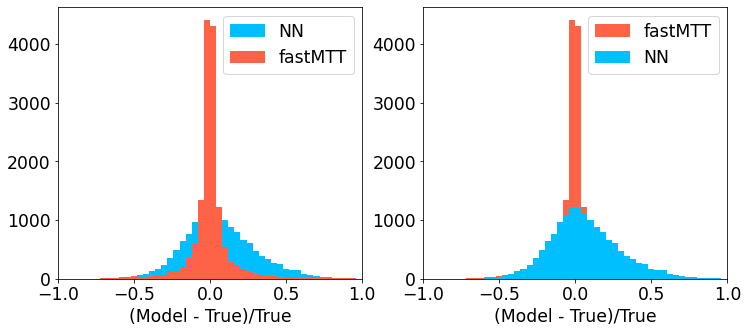

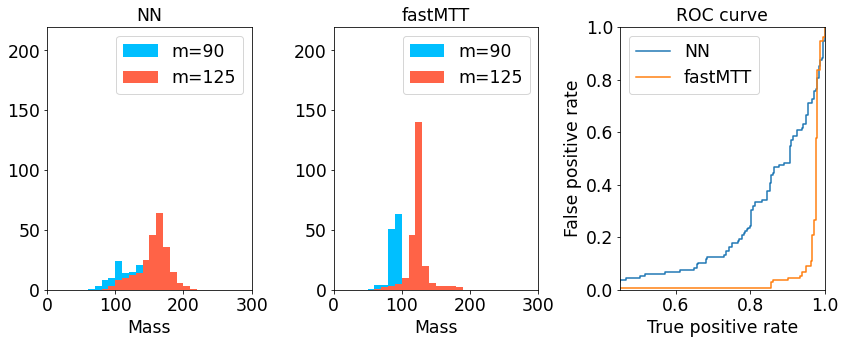

In [7]:
if not workOnPrometheus:
    nEpochsSaved = 10
    checkpoint_path = "training/model_weights_{epoch:04d}.ckpt"
    #model = getModel()
    #model.load_weights(checkpoint_path.format(epoch=nEpochsSaved)) 
    
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)

    testFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip') 
    #testFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8_smearMET.gzip')
    #testFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_DY_ggH125.gzip')
    test_dataset = loadDataset(testFileNames, isTrain=False, nEpochs=1, batchSize=15000)
    for aBatch in test_dataset.as_numpy_iterator():
            labels = aBatch[1]
            fastMTTPredictions = aBatch[2] 
            features = aBatch[0]
            predictions = model.predict(features, use_multiprocessing=True) 
            predictions = np.reshape(predictions, (-1))
            mVis = features[:,0]
            predictions = mVis/predictions
            labels = mVis/labels
                    
            plotPull(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)
            compareDYandH125(labels=labels, predictions=predictions, fastMTTPredictions=fastMTTPredictions)
            
            break

## Apply MET smearing

ValueError: 'low' is not a valid value for origin; supported values are 'upper', 'lower'

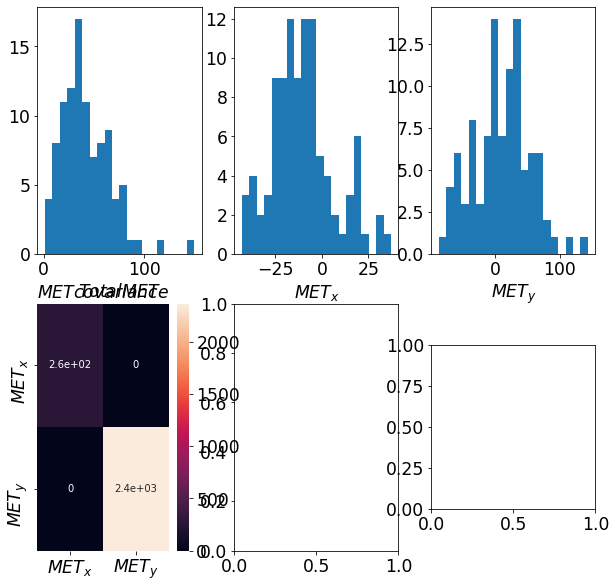

In [8]:
if not workOnPrometheus:

    nEpochsSaved = 20
    checkpoint_path = "training/model_weights_{epoch:04d}.ckpt"
    #model = getModel()
    #model.load_weights(checkpoint_path.format(epoch=nEpochsSaved))

    #testFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8.gzip') 
    testFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_Pythia8_smearMET.gzip')
    #testFileNames = glob.glob(dataDir + 'df.parquet_RootAnalysis_SVfitMLAnalysisMuTau_DY_ggH125.gzip')

    test_dataset = loadDataset(testFileNames, isTrain=False, nEpochs=1, batchSize=1)

    nSmearedElements = 100
    doPlotMET = True

    nnMTT = np.zeros_like(massBins)
    fastMTT = np.array([])
    labels = np.array([])

    for dataRow in test_dataset.take(1000):

      covariance = np.array(dataRow[3])
      covariance = np.reshape(covariance, (2,2)) 

      smearedBatch = generate_smeared_batch(dataRow, nSmearedElements)

      if doPlotMET:
          metX = smearedBatch[:,-2]
          metY = smearedBatch[:,-1] 
          plotMET(metX, metY, covariance)
          doPlotMET = False

      predictions = model.predict(smearedBatch, use_multiprocessing=True) 
      predictions = np.argmax(predictions, axis=1)   
      histo, edges = np.histogram(predictions, bins=np.linspace(0,massBins.shape[0],num=massBins.shape[0]+1))
      binNumber = np.argmax(histo) 
      predictions = np.zeros_like(massBins)
      predictions[binNumber] = 1.0   
      nnMTT = np.vstack((nnMTT, predictions))
      fastMTT = np.append(fastMTT, dataRow[2])
      labels = np.append(labels, dataRow[1])

    nnMTT = nnMTT[1:,:]    
    predictionsNN = np.argmax(nnMTT, axis=1)
    predictionsNN = label2Mass(predictionsNN) 
    plotPull(labels=labels, predictions=nnMTT, fastMTTPredictions=fastMTT)
    plotCM(labels=labels, predictions=nnMTT, fastMTTPredictions=fastMTT)
    compareDYandH125(labels=labels, predictions=predictionsNN, fastMTTPredictions=fastMTT)